## Workshop 3: Data Modeling
*Abhinav Pottabathula & Saarang Panchavati*


### Hello! Welcome to a workshop on data modeling. Here is the agenda for today:
 - Catchup & Modeling basics
 - Learn how to model EEG data
 - Practice with your own data!!

## What is modelling and why is it important?

We use data modeling to identify a sort of underlying distribution evident from the data, and analyze the data with hopes to unearth this valuable underlying distribution. This is of tremendous importance, and much of the work in this domain begins with empirical results and then as we understand the distribution, we try to build an understanding as to why this is an appropriate distribution for whatever phenomenon we are observing.

### Since all of us are at different levels of understanding, let's do a quick catchup assignment
https://www.kaggle.com/learn/intro-to-machine-learning

# A familiar but different use case!
## P300


<img style="height: 300px; float: right" src="P300_ERP.jpeg"/>


The P300 is a positive event-related potential (ERP) that occurs around 300ms after perceiving a novel or unexpected stimulus. It is most commonly elicited through 'oddball' experimental paradigms, where a certain subtype of stimulus is presented rarely amidst a background of another more common type of stimulus. Interestingly, the P300 is able to be elicited by multiple sensory modalities (e.g. visual, odditory, somatosensory). Thus, it is believed that the P300 may be a signature of higher level cognitive processing such as conscious attention.

In this notebook, we will attempt to elicit a P300 with a visual oddball stimulation paradigm using the Muse headband

## Step 1: Prepare the Data for Analysis
 
Since last week we learned how to acquire, clean, and visualize data, we will begin where we left off and start modelling data. There is a folder under Workshop 3 called data/auditory/P300, and it contains sample data which we will be analyzing.

### Load data into MNE objects

[MNE](https://martinos.org/mne/stable/index.html) is a very powerful Python library for analyzing EEG data. It provides helpful functions for performing key tasks such as filtering EEG data, rejecting artifacts, and grouping EEG data into chunks (epochs).

The first step to using MNE is to read the data we've collected into an MNE `Raw` object

In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
from utils import utils

# Define these parameters 
duration = 120 # in seconds. 120 is recommended
subject = 1 # unique id for each participant
session = 1 # represents a data collection session. Multiple trials can be performed for each session

In [41]:
raw = utils.load_data('visual/P300', sfreq=256., 
                      subject_nb=subject, session_nb=session)

Creating RawArray with float64 data, n_channels=5, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.


### Visualizing the Power Spectrum

Plotting the power spectral density (PSD) of our dataset will give us a glimpse at the different frequencies that are present. We won't be able to see the P300 in the PSD, but it will give us an impression of how noisy our data was. A very noisy or flat PSD may represent poor signal quality at certain electrodes



Effective window size : 8.000 (s)


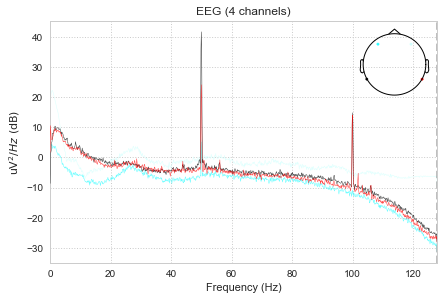

In [42]:
%matplotlib inline
raw.plot_psd();

This PSD looks good. There is a tremendous peak at 50hz and it's harmonic at 100hz. You can tell this dataset was collected in Europe because of the 50hz line noise

### Filtering

Most ERP components are composed of lower frequency fluctuations in the EEG signal. Thus, we can filter out all frequencies between 1 and 30 hz in order to increase our ability to detect them.

Setting up band-pass filter from 1 - 30 Hz
Setting up band-pass filter from 1 - 30 Hz
Setting up band-pass filter from 1 - 30 Hz
Setting up band-pass filter from 1 - 30 Hz
Setting up band-pass filter from 1 - 30 Hz
Setting up band-pass filter from 1 - 30 Hz
Effective window size : 8.000 (s)


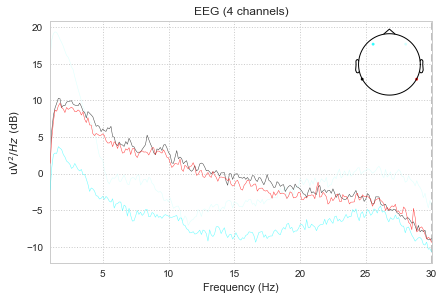

In [43]:
raw.filter(1,30, method='iir')
raw.plot_psd(fmin=1, fmax=30);

This PSD looks great. The AF8 electrode (Front right; light green) seems to have some noise in the signal, but the TP9 and TP10 electrodes (red and black) look great

### Epoching

Next, we will chunk (epoch) the data into segments representing the data 100ms before to 800ms after each stimulus. No baseline correction is needed (signal is bandpass filtered) and we will reject every epoch where the amplitude of the signal exceeded 75 uV, which should most eye blinks.

In [44]:
events = find_events(raw)
event_id = {'Non-Target': 1, 'Target': 2}

epochs = Epochs(raw, events=events, event_id=event_id, 
                tmin=-0.1, tmax=0.8, baseline=None,
                reject={'eeg': 100e-6}, preload=True, 
                verbose=False, picks=[0,1,2,3])
print('sample drop %: ', (1 - len(epochs.events)/len(events)) * 100)
epochs

1161 events found
Event IDs: [1 2]
sample drop %:  1.5503875968992276


<Epochs  |   1143 events (all good), -0.101562 - 0.800781 sec, baseline off, ~8.1 MB, data loaded,
 'Non-Target': 959
 'Target': 184>

Sample drop % is an important metric representing how noisy our data set was. If this is greater than 20%, consider ensuring that signal variances is very low in the raw EEG viewer and collecting more data

## Step 5: Analyze the Data

Finally, we can now analyze our results by averaging the epochs that occured during the different stimuli and looking for differences in the waveform


### Epoch average

With our `plot_conditions` utility function, we can plot the average ERP for all electrodes for both conditions:

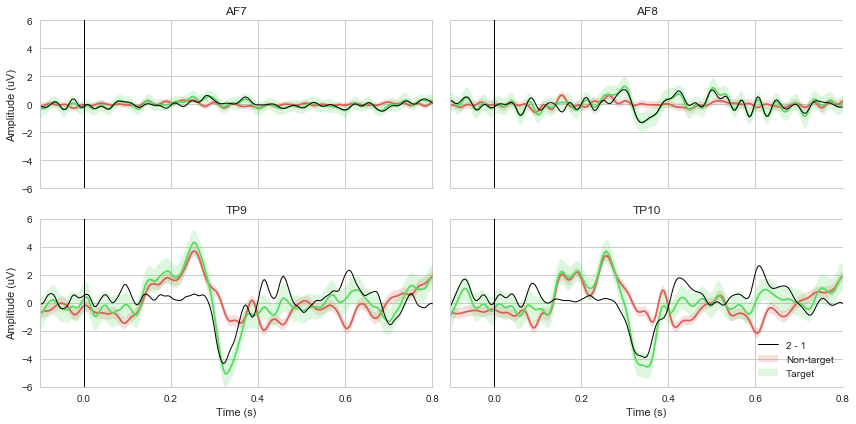

In [45]:
%matplotlib inline
conditions = OrderedDict()
conditions['Non-target'] = [1]
conditions['Target'] = [2]

fig, ax = utils.plot_conditions(epochs, conditions=conditions, 
                                ci=97.5, n_boot=1000, title='',
                                diff_waveform=(1, 2))

Here we can see a beautiful negative deflection in the EEG around 350ms after presentation of Target stimuli. The fact that it's occuring ~50ms later than expected is probably due to delay introduced by transmitting the data over bluetooth.

But wait, isn't this supposed to be a positive ERP? Well, yes, but the Muse's reference electrode is in a different location than traditional EEG systems (at the very front of the forehead instead of the top of the head or near the ear). Because of the location of the source of the P300 signal in the brain, this means that the direction of the P300 potential is inverted

## Let's watch some videos on Models!

### Basics:
[Covariance](https://www.youtube.com/watch?v=KDw3hC2YNFc)<br/>
Covariance is a measure of the joint variability of two random variables. ie. How two variables influence each other in a distribution. <br/>
[Linear Regression](https://www.youtube.com/watch?v=zPG4NjIkCjc)<br/>
Linear regression is a binary regression algorithm which classifies a dataset with either a 0 or 1 value. <br/>
[Logistic Regression](https://www.youtube.com/watch?v=yIYKR4sgzI8)<br/>
Logistic regression is a binary regression algorithm and it predicts a continuous outcome: the probability of an event. Logistic regression is a type of generalized linear regression model.<br/>
[Support Vector Machine (SVM)](https://www.youtube.com/watch?v=1NxnPkZM9bc)<br/>
A Support Vector Machine (SVM) is a discriminative classifier formally defined by a separating hyperplane. In other words, given labeled training data (supervised learning), the algorithm outputs an optimal hyperplane which categorizes new examples.

### EEG Models
[Click Here for Super Useful Models!](https://github.com/alexandrebarachant/pyRiemann) <br/>
[Riemannian Geometry](https://www.youtube.com/watch?v=IPrNIjA4AWE)<br/>
Takes into consideration various geometric models to classify data. Think of it as creating a sphere, saddle, or simple plane. <br/>
[Vectorization & Logistic Regression](https://www.youtube.com/watch?v=okpqeEUdEkY)<br/>
Vectorization is the process of rewriting a loop so that instead of processing a single element of an array N times, it processes (say) 4 elements of the array simultaneously N/4 times. <br/>
[Vectorization & Regularized LDA](https://www.youtube.com/watch?v=azXCzI57Yfc)<br/>
LDA allows for ‘fuzzy’ memberships. This provides a more nuanced way of recommending similar items, finding duplicates, or discovering user profiles/personas. In contrast k-means makes hard decision boundaries.
[ERP Covariance & Tangent Space Mapping](https://www.youtube.com/watch?v=tJHC2FVfhjA)<br/>
[ERP Covariance & MDM]()<br/>
A specific type of geometric classifier. <br/>

### Decoding the N170

Next, we will use 4 different machine learning pipelines to classify the P300 based on the data we collected.

- **Vect + LR** :  Vectorization of the trial + Logistic Regression. This can be considered the standard decoding pipeline for MEG / EEG.
- **Vect + RegLDA** :  Vectorization of the trial + Regularized LDA. This one is very commonly used in P300 BCIs. It can outperform the previous one but become unusable if the number of dimension is too high.
- **ERPCov + TS**: ErpCovariance + Tangent space mapping. One of the most reliable Riemannian geometry-based pipeline.
- **ERPCov + MDM**: ErpCovariance + MDM. A very simple, yet effective (for low channel count), Riemannian geometry classifier.

Evaluation is done through cross-validation, with area-under-the-curve (AUC) as metric (AUC is probably the best metric for binary and unbalanced classification problem)

*Note: because we're doing machine learning here, the following cell may take a while to complete*

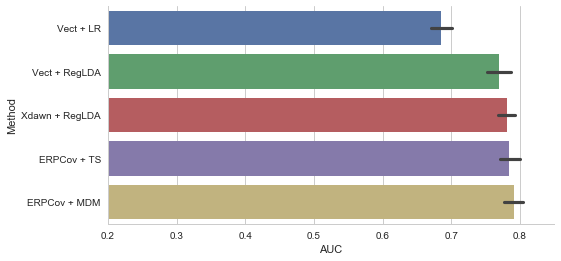

In [46]:
from sklearn.pipeline import make_pipeline

from mne.decoding import Vectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit

from pyriemann.estimation import ERPCovariances
from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import MDM
from pyriemann.spatialfilters import Xdawn

from collections import OrderedDict

clfs = OrderedDict()

clfs['Vect + LR'] = make_pipeline(Vectorizer(), StandardScaler(), LogisticRegression())
clfs['Vect + RegLDA'] = make_pipeline(Vectorizer(), LDA(shrinkage='auto', solver='eigen'))
clfs['Xdawn + RegLDA'] = make_pipeline(Xdawn(2, classes=[1]), Vectorizer(), LDA(shrinkage='auto', solver='eigen'))
clfs['ERPCov + TS'] = make_pipeline(ERPCovariances(), TangentSpace(), LogisticRegression())
clfs['ERPCov + MDM'] = make_pipeline(ERPCovariances(), MDM())

# format data
epochs.pick_types(eeg=True)
X = epochs.get_data() * 1e6
times = epochs.times
y = epochs.events[:, -1]

# define cross validation 
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.25, random_state=42)

# run cross validation for each pipeline
auc = []
methods = []
for m in clfs:
    res = cross_val_score(clfs[m], X, y==2, scoring='roc_auc', cv=cv, n_jobs=-1)
    auc.extend(res)
    methods.extend([m]*len(res))
    
results = pd.DataFrame(data=auc, columns=['AUC'])
results['Method'] = methods

plt.figure(figsize=[8,4])
sns.barplot(data=results, x='AUC', y='Method')
plt.xlim(0.2, 0.85)
sns.despine()

The best classifier for this dataset was ERP Covariance + MDM, which achieved an accuracy of around 0.77. This could be considered good enough for a BCI application, though one shouldn't expect outstanding results